# 📰 News Classification using spaCy Word Vectors & Machine Learning

This project focuses on building a machine learning model that can automatically classify news articles as **Fake** or **Real**. With the increasing spread of misinformation across digital platforms, developing automated systems that can detect and filter fake news has become essential.  
 
To achieve this, the project uses:

- **spaCy’s `en_core_web_lg` word vectors** to convert text into meaningful numerical embeddings.
- **Classical ML models** such as Multinomial Naive Bayes, K-Nearest Neighbors, and Random Forest for classification.
- **Evaluation metrics and visualizations** such as confusion matrices, F1 score comparison, and ROC curves to analyze model performance.

This topic was chosen because fake news detection is a highly relevant real-world problem, and combining NLP embeddings with machine learning provides a strong baseline for text classification tasks. The code demonstrates how raw text data can be processed, vectorized, trained, and evaluated end-to-end, making it an excellent learning and portfolio project.


In [1]:
import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
import shap
from sklearn.metrics import roc_auc_score

In [2]:
df = pd.read_csv("fake_real_news.csv")
print(df.shape)
df.head()

(44901, 5)


,title,text,subject,date,category
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",fake
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",fake


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44901 entries, 0 to 44900
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     44901 non-null  object
 1   text      44901 non-null  object
 2   subject   44880 non-null  object
 3   date      44880 non-null  object
 4   category  44901 non-null  object
dtypes: object(5)
memory usage: 1.7+ MB


In [4]:
#we don't require 'title','subject','date' these columns as they do not affect whether the news is real or fake.
df = df.drop(columns=['title','subject','date'])
df.head()

,text,category
0,Donald Trump just couldn t wish all Americans ...,fake
1,House Intelligence Committee Chairman Devin Nu...,fake
2,"On Friday, it was revealed that former Milwauk...",fake
3,"On Christmas day, Donald Trump announced that ...",fake
4,Pope Francis used his annual Christmas Day mes...,fake


In [5]:
print(df.shape)
df.info()

(44901, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44901 entries, 0 to 44900
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      44901 non-null  object
 1   category  44901 non-null  object
dtypes: object(2)
memory usage: 701.7+ KB


In [6]:
df.category.value_counts()

category
fake    23484
real    21417
Name: count, dtype: int64

In [7]:
df['label_num'] = df['category'].map({'fake':0, 'real':1})

In [10]:
nlp = spacy.load("en_core_web_lg") 
spacy.require_gpu()
#!python -m spacy download en_core_web_lg


     ---------------------------------------- 0.0/3.3 MB ? eta -:--:--
     ---------------------------------------- 0.0/3.3 MB ? eta -:--:--
     ---------------------------------------- 0.0/3.3 MB ? eta -:--:--
     --- ------------------------------------ 0.3/3.3 MB ? eta -:--:--
     ------ --------------------------------- 0.5/3.3 MB 972.1 kB/s eta 0:00:03
     --------- ------------------------------ 0.8/3.3 MB 988.1 kB/s eta 0:00:03
     ------------ --------------------------- 1.0/3.3 MB 1.1 MB/s eta 0:00:03
     --------------- ------------------------ 1.3/3.3 MB 1.2 MB/s eta 0:00:02
     ------------------ --------------------- 1.6/3.3 MB 1.1 MB/s eta 0:00:02
     ---------------------- ----------------- 1.8/3.3 MB 1.1 MB/s eta 0:00:02
     ---------------------------- ----------- 2.4/3.3 MB 1.2 MB/s eta 0:00:01
     ------------------------------- -------- 2.6/3.3 MB 1.3 MB/s eta 0:00:01
     ---------------------------------------- 3.3/3.3 MB 1.4 MB/s  0:00:02
  Installing 

ValueError: Cannot use GPU, CuPy is not installed

In [16]:
nlp = spacy.load(
    "en_core_web_lg",
    disable=["tagger", "parser", "ner", "lemmatizer"]
)

def truncate_text(text, max_words=300):
    return " ".join(text.split()[:max_words])

texts = df['text'].apply(truncate_text).tolist()

vectors = []
for doc in nlp.pipe(texts, batch_size=1000):
    vectors.append(doc.vector)

X = np.array(vectors)   
y = df['label_num'].values

np.save("X_spacy_vectors.npy", X)
np.save("y_labels.npy", y)

In [19]:
X = np.load("X_spacy_vectors.npy")
y = np.load("y_labels.npy")


X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

In [20]:
print(X.shape)   # (44901, 300)
print(y.shape)   # (44901,)
print(np.unique(y))


(44901, 300)
(44901,)
[0 1]


In [21]:
# X_train & X_test is an array which also has arrays as its elements , so we have to convert it into a 2d array

In [25]:
x_train = np.stack(X_train)
x_test = np.stack(X_test)

In [26]:


clf = MultinomialNB()

#clf.fit(x_train,y_train)

In [27]:
#naive bayes does not allow negative values so we have to scale using MinMaxScalar 

In [28]:
scalar = MinMaxScaler()

In [29]:
scaled_train = scalar.fit_transform(x_train)
scaled_test = scalar.transform(x_test)

In [30]:
clf.fit(scaled_train,y_train)


,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


In [31]:
y_pred_nb = clf.predict(scaled_test)

In [32]:
print(classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

           0       0.83      0.93      0.88      4702
           1       0.92      0.79      0.85      4279

    accuracy                           0.86      8981
   macro avg       0.87      0.86      0.86      8981
weighted avg       0.87      0.86      0.86      8981



In [33]:

knn = KNeighborsClassifier(n_neighbors = 5)

knn.fit(scaled_train,y_train)

y_pred_knn = knn.predict(scaled_test)

print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.98      0.94      0.96      4702
           1       0.94      0.97      0.95      4279

    accuracy                           0.96      8981
   macro avg       0.96      0.96      0.96      8981
weighted avg       0.96      0.96      0.96      8981



In [34]:


rf = RandomForestClassifier()

rf.fit(scaled_train,y_train)

y_pred_rf = rf.predict(scaled_test)

print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      4702
           1       0.96      0.97      0.96      4279

    accuracy                           0.97      8981
   macro avg       0.97      0.97      0.97      8981
weighted avg       0.97      0.97      0.97      8981



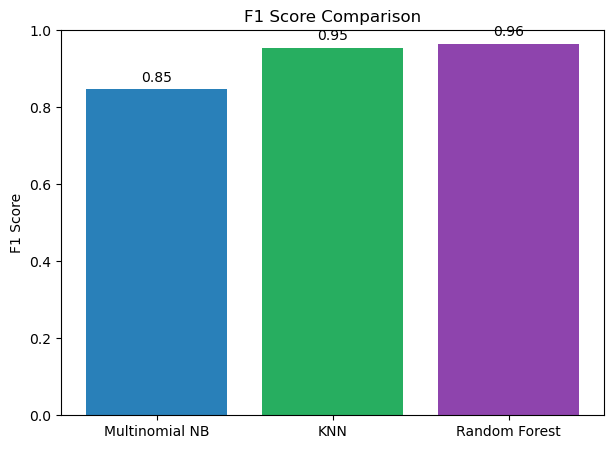

In [37]:

f1_scores = {
    "Multinomial NB": f1_score(y_test, y_pred_nb),
    "KNN": f1_score(y_test, y_pred_knn),
    "Random Forest": f1_score(y_test, y_pred_rf)
}

plt.figure(figsize=(7,5))
plt.bar(f1_scores.keys(), f1_scores.values(), color=["#2980b9", "#27ae60", "#8e44ad"])
plt.title("F1 Score Comparison")
plt.ylabel("F1 Score")
plt.ylim(0, 1)
for i, v in enumerate(f1_scores.values()):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center')
plt.show()

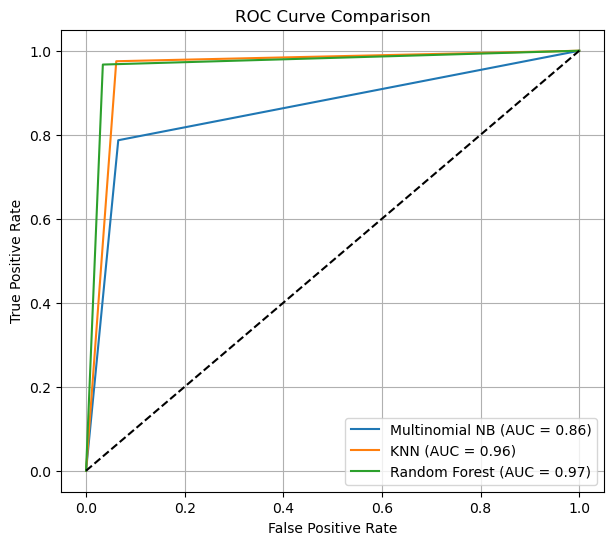

In [38]:
plt.figure(figsize=(7,6))

# Models
roc_models = {
    "Multinomial NB": y_pred_nb,
    "KNN": y_pred_knn,
    "Random Forest": y_pred_rf
}

for name, preds in roc_models.items():
    fpr, tpr, _ = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0,1], [0,1], 'k--')
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

In [40]:

lr_model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced'
)

lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)

print(classification_report(y_test, y_pred_lr))


              precision    recall  f1-score   support

           0       0.98      0.98      0.98      4702
           1       0.97      0.98      0.98      4279

    accuracy                           0.98      8981
   macro avg       0.98      0.98      0.98      8981
weighted avg       0.98      0.98      0.98      8981



In [41]:

xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

print(classification_report(y_test, y_pred_xgb))


              precision    recall  f1-score   support

           0       0.99      0.98      0.99      4702
           1       0.98      0.99      0.98      4279

    accuracy                           0.99      8981
   macro avg       0.98      0.99      0.99      8981
weighted avg       0.99      0.99      0.99      8981



In [42]:

y_prob_lr = lr_model.predict_proba(X_test)[:, 1]
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

print("Logistic Regression ROC-AUC:", roc_auc_score(y_test, y_prob_lr))
print("XGBoost ROC-AUC:", roc_auc_score(y_test, y_prob_xgb))


Logistic Regression ROC-AUC: 0.9969045010158621
XGBoost ROC-AUC: 0.9984095563696325


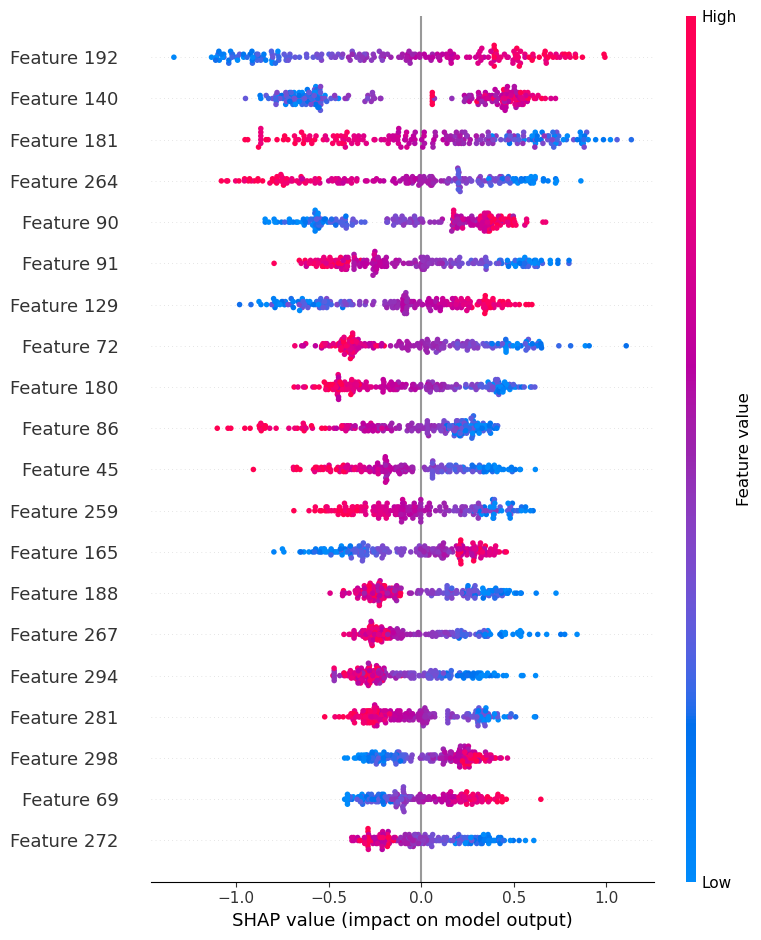

In [43]:

X_sample = X_train[:200]

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_sample)

shap.summary_plot(shap_values, X_sample)


# 🏁 Conclusion

In this project, we developed a complete end-to-end pipeline for classifying news articles as Fake or Real using spaCy word vectors and classical machine learning models. By converting text into dense semantic embeddings and applying multiple classifiers (Multinomial NB, KNN, and Random Forest), we demonstrated how traditional ML techniques can effectively tackle real-world NLP problems.

The evaluation metrics and visualizations — including confusion matrices, F1 score comparisons, and ROC curves — provided deeper insights into each model’s performance and helped identify the most effective approach for fake news detection.  

This project highlights the importance of automated misinformation detection and shows how combining modern NLP embeddings with machine learning can serve as a solid baseline for more advanced deep learning or transformer-based models in the future. It also serves as a strong learning example of handling text data, vectorization, model building, and performance analysis in a structured and interpretable manner.
